# tf_data 이용하여 이미지 데이터셋과 배치 만들어 모델링

## tf.data.Dataset 이용하여 데이터셋 만들기

In [1]:
import os 
from glob import glob

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!git clone https://github.com/YoongiKim/CIFAR-10-images.git

Cloning into 'CIFAR-10-images'...
remote: Enumerating objects: 60027, done.
remote: Total 60027 (delta 0), reused 0 (delta 0), pack-reused 60027
Receiving objects: 100% (60027/60027), 19.94 MiB | 22.24 MiB/s, done.
Resolving deltas: 100% (59990/59990), done.
Checking out files: 100% (60001/60001), done.


In [4]:
# CIFAR-10-images 폴더 밑에 train, test 폴더 있음
!ls -l CIFAR-10-images/

total 12
-rw-r--r--  1 root root   95 May 24 05:06 README.md
drwxr-xr-x 12 root root 4096 May 24 05:06 test
drwxr-xr-x 12 root root 4096 May 24 05:07 train


In [5]:
# CIFAR-10-images/train 폴더 밑에 각각 Class별 폴더 이름 있음
!ls -l CIFAR-10-images/train

total 1280
drwxr-xr-x 2 root root 131072 May 24 05:06 airplane
drwxr-xr-x 2 root root 131072 May 24 05:06 automobile
drwxr-xr-x 2 root root 131072 May 24 05:06 bird
drwxr-xr-x 2 root root 131072 May 24 05:06 cat
drwxr-xr-x 2 root root 131072 May 24 05:06 deer
drwxr-xr-x 2 root root 131072 May 24 05:07 dog
drwxr-xr-x 2 root root 131072 May 24 05:07 frog
drwxr-xr-x 2 root root 131072 May 24 05:07 horse
drwxr-xr-x 2 root root 131072 May 24 05:07 ship
drwxr-xr-x 2 root root 131072 May 24 05:07 truck


In [9]:
# CIFAR-10-images/train/airplane 폴더 밑에 비행기 그림들이 있음
!ls -l CIFAR-10-images/train/airplane | head

total 20000
-rw-r--r-- 1 root root  924 May 24 05:06 0000.jpg
-rw-r--r-- 1 root root  890 May 24 05:06 0001.jpg
-rw-r--r-- 1 root root  930 May 24 05:06 0002.jpg
-rw-r--r-- 1 root root  983 May 24 05:06 0003.jpg
-rw-r--r-- 1 root root  865 May 24 05:06 0004.jpg
-rw-r--r-- 1 root root  901 May 24 05:06 0005.jpg
-rw-r--r-- 1 root root  866 May 24 05:06 0006.jpg
-rw-r--r-- 1 root root  941 May 24 05:06 0007.jpg
-rw-r--r-- 1 root root  823 May 24 05:06 0008.jpg


###  1. 이미지 파일 하나 읽어 이미지 보기

In [12]:
path = './CIFAR-10-images/train/airplane/0000.jpg'

In [13]:
gfile = tf.io.read_file(path)
image = tf.io.decode_image(gfile, dtype=tf.float32)

In [14]:
image.shape

TensorShape([32, 32, 3])

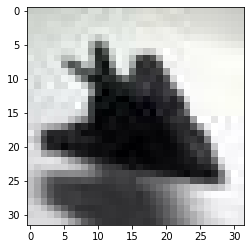

In [15]:
plt.imshow(image)
plt.show()

### 2. tf.data.Dataset from_tensor_slices 이용하기

In [16]:
train_paths = glob('./CIFAR-10-images/train/*/*.jpg')
print(len(train_paths))
print(train_paths[-10:])

50000
['./CIFAR-10-images/train/frog/2342.jpg', './CIFAR-10-images/train/frog/2218.jpg', './CIFAR-10-images/train/frog/4123.jpg', './CIFAR-10-images/train/frog/3725.jpg', './CIFAR-10-images/train/frog/0656.jpg', './CIFAR-10-images/train/frog/1260.jpg', './CIFAR-10-images/train/frog/4255.jpg', './CIFAR-10-images/train/frog/3192.jpg', './CIFAR-10-images/train/frog/4746.jpg', './CIFAR-10-images/train/frog/3841.jpg']


In [17]:
# 이미지 이름 주면 이미지 읽어 반환
def read_image(path):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile, dtype=tf.float32)
    return image

In [18]:
# map 변환 병렬화
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [19]:
# 이미지 읽어올 패스 지정(from_tensor_slices)하고 해당 패스에서 map 함수를 통해 이미지 읽어오기

dataset = tf.data.Dataset.from_tensor_slices(train_paths)
dataset = dataset.map(read_image, num_parallel_calls=AUTOTUNE)

In [20]:
# 데이터셋에서 1개 이미지 가져오기
tf_image = next(iter(dataset))
tf_image.shape

TensorShape([32, 32, 3])

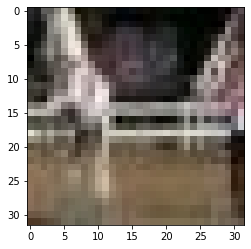

In [21]:
plt.imshow(tf_image)
plt.show()

### 3.  Batch로 묶기

In [22]:
# 4개 batch 묶기
dataset = tf.data.Dataset.from_tensor_slices(train_paths)
dataset = dataset.map(read_image)
dataset = dataset.batch(4)

In [23]:
tf_images = next(iter(dataset))
tf_images.shape

TensorShape([4, 32, 32, 3])

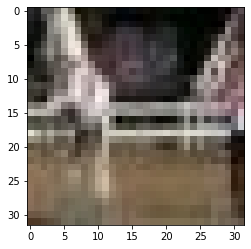

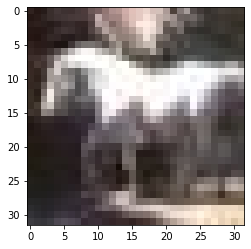

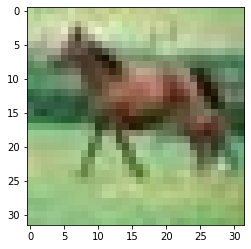

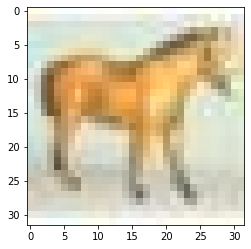

In [24]:
for i in range(4):
    plt.imshow(tf_images[i])
    plt.show()

### 4. cache, Shuffle, batch, prefetch 하기

In [25]:
len(train_paths)

50000

In [26]:
# repeat 안주면 1 epoch에서 끝나게 되므로 여러 epoch할 경우 repeat 주어야 함.
dataset = tf.data.Dataset.from_tensor_slices(train_paths)
dataset = dataset.map(read_image, num_parallel_calls=AUTOTUNE)
dataset = dataset.cache()
dataset = dataset.batch(4)
dataset = dataset.shuffle(buffer_size=len(train_paths))
dataset = dataset.prefetch(buffer_size=AUTOTUNE)

In [27]:
# shuffle 시간 좀 걸림
tf_images = next(iter(dataset))
tf_images.shape

TensorShape([4, 32, 32, 3])

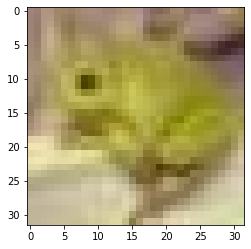

In [28]:
# shuffle 이전에 첫번째 이미지와 지금은 다른 이미지로 shuffle 되것 확인
plt.imshow(tf_images[0])
plt.show()

## tf.data.Dataset 이용 및 모델링

### 1. 라이브러리 import

In [30]:
import os
from glob import glob
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import datasets 

%matplotlib inline

### 2. Hyperparameter Tunning

In [116]:
num_epochs = 10 
batch_size = 32

learning_rate = 0.001

dropout_rate = 0.5

input_shape = (32, 32, 3)
num_classes = 10

### 3. Data Preprocess

In [47]:
train_paths_list = glob('./CIFAR-10-images/train/*/*.jpg')
test_paths_list = glob('./CIFAR-10-images/test/*/*.jpg')

In [48]:
# 리스트 섞어 주기
#train_paths = np.random.permutation(train_paths_list)[:10000]
#test_paths = np.random.permutation(test_paths_list)[:1000]

train_paths = np.random.permutation(train_paths_list)
test_paths = np.random.permutation(test_paths_list)

In [49]:
train_paths[:10]

array(['./CIFAR-10-images/train/automobile/0559.jpg',
       './CIFAR-10-images/train/cat/0961.jpg',
       './CIFAR-10-images/train/frog/1515.jpg',
       './CIFAR-10-images/train/automobile/0359.jpg',
       './CIFAR-10-images/train/ship/3321.jpg',
       './CIFAR-10-images/train/ship/0894.jpg',
       './CIFAR-10-images/train/ship/2786.jpg',
       './CIFAR-10-images/train/bird/0241.jpg',
       './CIFAR-10-images/train/ship/3740.jpg',
       './CIFAR-10-images/train/automobile/0507.jpg'], dtype='<U43')

In [50]:
len(train_paths), len(test_paths)

(50000, 10000)

In [95]:
def get_class_name(path):
    fname = os.path.dirname(path).split('/')[-1] 
    return fname

In [96]:
for path in train_paths[:10]:
  print(get_class_name(path))

automobile
cat
frog
automobile
ship
ship
ship
bird
ship
automobile


In [97]:
train_labels = [get_class_name(path) for path in train_paths]
class_names = np.unique(train_labels)
class_names

array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
       'horse', 'ship', 'truck'], dtype='<U10')

In [98]:
def get_label(path):
    fname = tf.strings.split(path, '/')[-2]
    onehot = tf.cast(fname == class_names, tf.uint8)
    #return tf.argmax(onehot)  # 이번에는 onehot이 아닌 label 번호로
    return onehot              # 이번에는 onehot으로

In [99]:
def load_image_label(path):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    image = tf.cast(image, tf.float32) / 255.  # rescale
    
    label = get_label(path)
    return image, label

In [100]:
def image_preprocess(image, label):
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_flip_left_right(image)
    return image, label

In [101]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [102]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
train_dataset = train_dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
#train_dataset = train_dataset.map(image_preprocess, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(buffer_size=len(train_paths))
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(AUTOTUNE) 

In [103]:
# test set은 shuffle 하지 않음
test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)
test_dataset = test_dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.cache()
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(AUTOTUNE)

In [104]:
len(train_dataset) * 32 , len(test_dataset) * 32 

(50016, 10016)

### 1 ~ 3까지의 과정을 image_dataset_from_directory 이용하여 간단하게 할수 있다.
### <font color=red>단, image/train, test 폴더 있고 그 아래 각 class별 이름 폴더가 있고 class별 폴더 안에 이미지 파일 있을 경우</font>
- 이미지 메모리 올리기
- 라벨 구분, 라벨 one-hot-encoding
- 이미지, 라벨 튜플 묶고, shuffle, batch

In [117]:
# Train, Test path 지정

train_dir='./CIFAR-10-images/train'
test_dir='./CIFAR-10-images/test'

In [118]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_ds = image_dataset_from_directory(directory=train_dir,
                                             label_mode="categorical",   # binary , categorical
                                             batch_size=batch_size,
                                             image_size=(32, 32),
                                             shuffle=True,
                                             #validation_split=0.2,
                                            )

Found 50000 files belonging to 10 classes.


In [119]:
test_ds = image_dataset_from_directory(directory=test_dir,
                                             label_mode="categorical",   # binary , categorical
                                             batch_size=batch_size,
                                             image_size=(32, 32),
                                             shuffle=False,
                                             #validation_split=0.2,
                                            )

Found 10000 files belonging to 10 classes.


In [120]:
# prefetch 적용

train_dataset = train_ds.prefetch(AUTOTUNE) 
test_dataset = test_ds.prefetch(AUTOTUNE)

In [121]:
# Train, Test 건수 확인
len(train_ds) * 32 , len(test_ds) * 32

(50016, 10016)

(32, 32, 3)


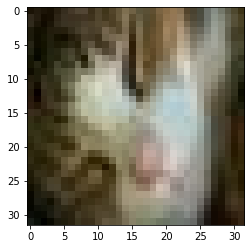

In [122]:
# 샘플 이미지 확인

i = 0
for batch_img, batch_label in  train_ds.take(1):
  if i == 0 :
    print(batch[i].shape)
    plt.imshow(batch_img[i]/255)
  i = i + 1
  

### 4. Build Model

In [123]:
inputs = layers.Input(input_shape)

net = layers.Conv2D(32, (3, 3), padding='SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Flatten()(net)
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(dropout_rate)(net)
net = layers.Dense(num_classes)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name='Basic_CNN')

In [124]:
# Model is the full model w/o custom layers
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),  # Optimization
              loss='categorical_crossentropy',  # Loss Function 
              metrics=['accuracy'])  # Metrics / Accuracy

In [125]:
model.summary()

Model: "Basic_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_12 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_13 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 32)        0 

## Learning Raate Scheduler

In [126]:
import math

In [127]:
def scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:
        return 0.001 * math.exp(0.1 * (10 - epoch))

learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

## Training

In [128]:
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=[learning_rate_scheduler]
)

Epoch 1/15
1563/1563 [==============================] - 23s 14ms/step - loss: 3.1263 - accuracy: 0.2200 - val_loss: 1.5681 - val_accuracy: 0.4372
Epoch 2/15
1563/1563 [==============================] - 23s 14ms/step - loss: 1.5836 - accuracy: 0.4212 - val_loss: 1.3350 - val_accuracy: 0.5365
Epoch 3/15
1563/1563 [==============================] - 22s 14ms/step - loss: 1.4439 - accuracy: 0.4809 - val_loss: 1.2981 - val_accuracy: 0.5530
Epoch 4/15
1563/1563 [==============================] - 22s 14ms/step - loss: 1.3681 - accuracy: 0.5111 - val_loss: 1.2200 - val_accuracy: 0.5750
Epoch 5/15
1563/1563 [==============================] - 22s 14ms/step - loss: 1.3220 - accuracy: 0.5311 - val_loss: 1.1833 - val_accuracy: 0.5820
Epoch 6/15
1563/1563 [==============================] - 23s 14ms/step - loss: 1.2871 - accuracy: 0.5415 - val_loss: 1.1438 - val_accuracy: 0.5908
Epoch 7/15
1563/1563 [==============================] - 23s 15ms/step - loss: 1.2593 - accuracy: 0.5570 - val_loss: 1.1473 -

## history

In [129]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

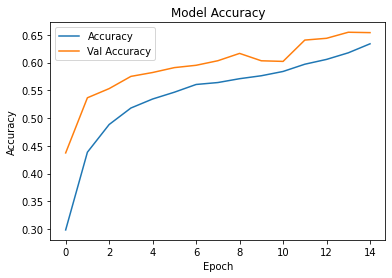

In [130]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

## Predict

### 1. 이미지를 Load 직접 load해서 넣는 방법

In [131]:
path = test_paths[0]
test_image, test_label = load_image_label(path)

In [132]:
test_image.shape, test_label

(TensorShape([32, 32, 3]),
 <tf.Tensor: shape=(10,), dtype=uint8, numpy=array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0], dtype=uint8)>)

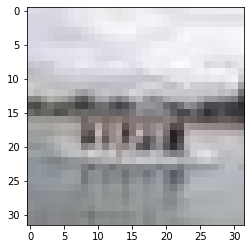

In [133]:
plt.imshow(test_image)

In [134]:
test_image = test_image[tf.newaxis, ...]
test_image.shape

TensorShape([1, 32, 32, 3])

In [135]:
pred = model.predict(test_image)

In [136]:
pred

array([[5.7290527e-03, 1.1602244e-03, 1.3308777e-01, 1.4068368e-01,
        6.6060555e-01, 8.4662195e-03, 3.5484444e-02, 1.2783650e-02,
        1.8348597e-03, 1.6455198e-04]], dtype=float32)

In [137]:
np.argmax(pred)

4